In [ ]:
!pip install -q tensorflow-text

     |████████████████████████████████| 2.6MB 12.5MB/s 


In [ ]:
!pip install -q tf-models-official

     |████████████████████████████████| 849kB 13.5MB/s 
     |████████████████████████████████| 36.7MB 60.5MB/s 
     |████████████████████████████████| 358kB 48.2MB/s 
     |████████████████████████████████| 174kB 48.1MB/s 
     |████████████████████████████████| 1.1MB 43.7MB/s 
     |████████████████████████████████| 102kB 11.8MB/s 


In [ ]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [ ]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclIdb_v1.tar.gz', url, untar=True, cache_dir='.', cache_subdir='')
dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
train_dir = os.path.join(dataset_dir, 'train')

remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)


84131840/84125825 [==============================] - 11s 0us/step


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed
)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed
)

val_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size
)

test_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)




Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [ ]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    tbatch = text_batch.numpy()[i]
    print(f'Review: {tbatch}')
    label = label_batch.numpy()[i]
    print(f'Label: {label} ({class_names[label]})')


Review: b'Silent Night, Deadly Night 5 is the very last of the series, and like part 4, it\'s unrelated to the first three except by title and the fact that it\'s a Christmas-themed horror flick.<br /><br />Except to the oblivious, there\'s some obvious things going on here...Mickey Rooney plays a toymaker named Joe Petto and his creepy son\'s name is Pino. Ring a bell, anyone? Now, a little boy named Derek heard a knock at the door one evening, and opened it to find a present on the doorstep for him. Even though it said "don\'t open till Christmas", he begins to open it anyway but is stopped by his dad, who scolds him and sends him to bed, and opens the gift himself. Inside is a little red ball that sprouts Santa arms and a head, and proceeds to kill dad. Oops, maybe he should have left well-enough alone. Of course Derek is then traumatized by the incident since he watched it from the stairs, but he doesn\'t grow up to be some killer Santa, he just stops talking.<br /><br />There\'s a

In [ ]:
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1'

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/1


In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [ ]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys               : { list(text_preprocessed.keys())}')
print(f'Shape             : { text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids        : { text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask     : { text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids         : { text_preprocessed["input_type_ids"][0, :12]}')


Keys               : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape             : (1, 128)
Word Ids        : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask     : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids         : [0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT                     : { tfhub_handle_encoder}')
print(f'Pooled Outputs Shape         : { bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values        : { bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape    : { bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values   : { bert_results["sequence_output"][0, :12]}')


Loaded BERT                     : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape         : (1, 512)
Pooled Outputs Values        : [ 0.76262915  0.99280983 -0.18611857  0.3667384   0.15233715  0.6550451
  0.9681154  -0.948627    0.00216166 -0.9877732   0.06842688 -0.9763059 ]
Sequence Outputs Shape    : (1, 128, 512)
Sequence Outputs Values   : [[-0.28946406  0.34321284  0.33231527 ...  0.21300796  0.7102072
  -0.05771175]
 [-0.2874205   0.31981015 -0.23018587 ...  0.5845504  -0.21329752
   0.72692037]
 [-0.66157055  0.68876845 -0.8743293  ...  0.1087724  -0.26173186
   0.47855398]
 ...
 [-0.22561164 -0.28925577 -0.07064409 ...  0.47565955  0.8327713
   0.40025365]
 [-0.29824203 -0.2747312  -0.05450513 ...  0.4884973   1.0955358
   0.18163405]
 [-0.44378182  0.00930732  0.07223705 ...  0.17290123  1.1833236
   0.07897992]]


In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.6298188]], shape=(1, 1), dtype=float32)


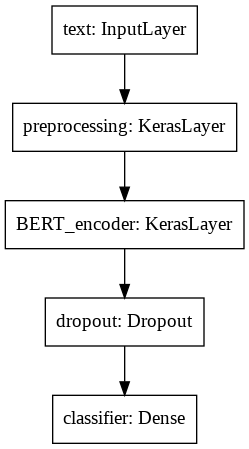

In [ ]:
tf.keras.utils.plot_model(classifier_model)

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [ ]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')


In [ ]:
classifier_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5
625/625 [==============================] - 4736s 8s/step - loss: 0.4927 - binary_accuracy: 0.7332 - val_loss: 0.3153 - val_binary_accuracy: 0.8490
Epoch 2/5
625/625 [==============================] - 4762s 8s/step - loss: 0.3217 - binary_accuracy: 0.8572 - val_loss: 0.2233 - val_binary_accuracy: 0.8963
Epoch 3/5
625/625 [==============================] - 4747s 8s/step - loss: 0.2375 - binary_accuracy: 0.8982 - val_loss: 0.1331 - val_binary_accuracy: 0.9446
Epoch 4/5
625/625 [==============================] - 4730s 8s/step - loss: 0.1742 - binary_accuracy: 0.9306 - val_loss: 0.0876 - val_binary_accuracy: 0.9691
Epoch 5/5
625/625 [==============================] - 4739s 8s/step - loss: 0.1298 - binary_accuracy: 0.9507 - val_loss: 0.0691 - val_binary_accuracy: 0.9791


In [ ]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

625/625 [==============================] - 1013s 2s/step - loss: 0.0691 - binary_accuracy: 0.9791
Loss: 0.06907320022583008
Accuracy: 0.9790999889373779


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


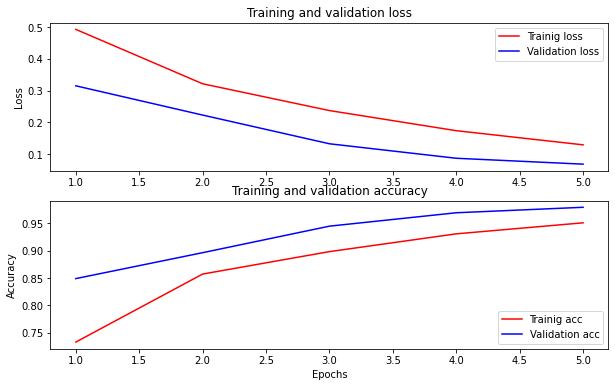

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10,6))
fig.tight_layout()

plt.subplot(2, 1, 1)
plt.plot(epochs, loss, 'r', label='Trainig loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Trainig acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')







In [ ]:
dataset_name = 'imdb'
saved_model_path = './{}_bert'.format( dataset_name.replace('/','_') )

classifier_model.save(saved_model_path, include_optimizer=False)

In [ ]:
reloaded_model = tf.saved_model.load(saved_model_path)

In [ ]:
def print_my_examples(inputs, results):
  result_for_printing = [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}' for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()

examples = [
            'this is such an amazing movie!',
            'The movie was great!',
            'The movie was meh.',
            'The movie was super',
            'The movie was okish.',
            'The movie was not good.',
            'The movie was terrible...'
]

reloaded_results = tf.sigmoid( reloaded_model(tf.constant(examples)) )
original_results = tf.sigmoid( classifier_model(tf.constant(examples)) )

print('Results from the saved model: ')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory: ')
print_my_examples(examples, original_results)


Results from the saved model: 
input: this is such an amazing movie! : score: 0.999704
input: The movie was great!           : score: 0.997739
input: The movie was meh.             : score: 0.804118
input: The movie was super            : score: 0.547437
input: The movie was okish.           : score: 0.008605
input: The movie was not good.        : score: 0.001641
input: The movie was terrible...      : score: 0.001557

Results from the model in memory: 
input: this is such an amazing movie! : score: 0.999704
input: The movie was great!           : score: 0.997739
input: The movie was meh.             : score: 0.804118
input: The movie was super            : score: 0.547437
input: The movie was okish.           : score: 0.008605
input: The movie was not good.        : score: 0.001641
input: The movie was terrible...      : score: 0.001557

